In [6]:
import pandas as pd
import os

base = "/Users/adithyamadduri/Downloads/syn65414912"

# Load the key files
df_levels_anml   = pd.read_csv(os.path.join(base, "OhNM2025_ROSMAP_plasma_Soma7k_protein_level_ANML_log10.csv"))
df_levels_log10  = pd.read_csv(os.path.join(base, "OhNM2025_ROSMAP_plasma_Soma7k_protein_level_log10.csv"))
df_protein_meta  = pd.read_csv(os.path.join(base, "OhNM2025_ROSMAP_plasma_Soma7k_protein_metadata.csv"))
df_sample_meta   = pd.read_csv(os.path.join(base, "OhNM2025_ROSMAP_plasma_Soma7k_sample_metadata.csv"))

# Quick checks
print("Protein levels (ANML):", df_levels_anml.shape)
print("Protein levels (log10):", df_levels_log10.shape)
print("Protein metadata:", df_protein_meta.shape)
print("Sample metadata:", df_sample_meta.shape)

# Preview sample metadata (patients)
print("\n=== Sample Metadata Head ===")
print(df_sample_meta.head())

# Preview protein metadata
print("\n=== Protein Metadata Head ===")
print(df_protein_meta.head())

Protein levels (ANML): (973, 7290)
Protein levels (log10): (973, 7290)
Protein metadata: (7289, 42)
Sample metadata: (973, 12)

=== Sample Metadata Head ===
  projid_visit    projid  Visit study  msex  age_at_visit Diagnosis  \
0  R4014413_01  R4014413      1  MAP      0     87.876797       MCI   
1  R5357999_02  R5357999      2  MAP      0     99.071869       AD+   
2  R7139444_13  R7139444     13  MAP      0     97.935661       NCI   
3  R7095349_03  R7095349      3  ROS      0     94.182067        AD   
4  R4364014_00  R4364014      0  MAP      0     92.605065        AD   

   cogn_global  apoe_genotype  educ   age_death  Storage_days  
0    -1.054759           34.0    16   92.783025        6566.0  
1    -0.988238           23.0    16  102.091718        6566.0  
2     1.133552           33.0    21  107.679671        4222.0  
3          NaN           33.0    16   95.310062        6535.0  
4    -1.429396           33.0    12   97.456537        6535.0  

=== Protein Metadata Head ===
 

In [19]:
# =========================
# BLOCK 1 — PREPROCESSING
# =========================
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# ---- File paths ----
BASE = "/Users/adithyamadduri/Downloads/syn65414912"
ANML_PATH   = os.path.join(BASE, "OhNM2025_ROSMAP_plasma_Soma7k_protein_level_ANML_log10.csv")
SAMPLE_PATH = os.path.join(BASE, "OhNM2025_ROSMAP_plasma_Soma7k_sample_metadata.csv")

# ---- Load ----
df_levels = pd.read_csv(ANML_PATH)        # rows: projid_visit, cols: proteins
df_meta   = pd.read_csv(SAMPLE_PATH)      # contains projid_visit, projid, msex, age_at_visit, educ, apoe_genotype, Diagnosis

# ---- Sanity: keys present? ----
assert "projid_visit" in df_levels.columns, "projid_visit missing in protein matrix."
for col in ["projid_visit","projid","msex","age_at_visit","educ","apoe_genotype","Diagnosis"]:
    assert col in df_meta.columns, f"{col} missing in sample metadata."

# ---- Align on visit ----
# inner join so we only keep visits present in BOTH
df = pd.merge(df_meta, df_levels, on="projid_visit", how="inner", validate="one_to_one")
print("Aligned shape:", df.shape)

# ---- Labels (four groups) ----
df["Diagnosis"] = df["Diagnosis"].astype(str).str.strip()
valid_classes = {"MCI","NCI","AD","AD+"}
df = df[df["Diagnosis"].isin(valid_classes)].reset_index(drop=True)
print("Class counts:\n", df["Diagnosis"].value_counts())

# ---- Grouping key for leakage control ----
df["projid"] = df["projid"].astype(str)

# ---- Stratification label: Diagnosis × sex (0/1) ----
df["msex"] = df["msex"].astype(int)
df["strata"] = df["Diagnosis"] + "_" + df["msex"].astype(str)

# ---- APOE one-hot (Unknown for NaN) ----
def format_apoe(x):
    if pd.isna(x):
        return "Unknown"
    try:
        # e.g., 33.0 -> "33"
        return str(int(float(x)))
    except Exception:
        s = str(x).strip()
        return s if s else "Unknown"

df["apoe_str"] = df["apoe_genotype"].apply(format_apoe)

# scikit-learn compatibility across versions
try:
    ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
except TypeError:
    ohe = OneHotEncoder(sparse=False, handle_unknown="ignore")

apoe_ohe = ohe.fit_transform(df[["apoe_str"]])
apoe_cols = [c.replace("apoe_str_","APOE_") for c in ohe.get_feature_names_out()]
df_apoe  = pd.DataFrame(apoe_ohe, columns=apoe_cols, index=df.index)

# ---- Numeric covariates (unscaled) ----
for col in ["age_at_visit","educ"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# ---- Protein feature columns ----
protein_cols = [c for c in df_levels.columns if c != "projid_visit"]

# ---- Final feature matrix X ----
X = pd.concat([df[["age_at_visit","educ"]], df_apoe, df[protein_cols]], axis=1)
y = df["Diagnosis"].astype(str).values
groups = df["projid"].values
strata = df["strata"].values

print("X shape:", X.shape)
print("APOE levels seen:", sorted(set(df["apoe_str"])))

Aligned shape: (973, 7301)
Class counts:
 Diagnosis
NCI    507
MCI    262
AD     167
AD+     17
Name: count, dtype: int64
X shape: (953, 7298)
APOE levels seen: ['22', '23', '24', '33', '34', '44', 'Unknown']


In [20]:
# === VISIT-LEVEL SUMMARY (standalone) ===
print("\n=== Visit-level summary ===")
print(f"Total patient visits: {len(df)}")

# Visits per diagnosis class (NCI, MCI, AD, AD+), missing classes shown as 0
order = ["NCI", "MCI", "AD", "AD+"]
counts = df["Diagnosis"].value_counts().reindex(order).fillna(0).astype(int)

print("Visits per class:")
for cls, cnt in counts.items():
    print(f"  {cls}: {cnt}")


=== Visit-level summary ===
Total patient visits: 953
Visits per class:
  NCI: 507
  MCI: 262
  AD: 167
  AD+: 17


In [13]:
# =========================
# BLOCK 2 — TRAINING RF
# =========================
import os
import numpy as np
import pandas as pd
from flaml import AutoML
from sklearn.metrics import roc_auc_score

# ---- Output folder ----
out_dir = "/Users/adithyamadduri/Desktop/Projects/proteomics_RF(ANML+Meta)"
os.makedirs(out_dir, exist_ok=True)

# ---- Helper: group-aware stratified 70/30 split (by mode of strata per subject) ----
def group_stratified_shuffle_split(df_index, strata_all, groups_all, test_size=0.30, random_state=0):
    """Return train_idx, test_idx ensuring groups stay intact and class-sex balance is approx preserved.
       Strategy: assign each group a single stratum = mode(strata) among its rows, then stratified split at group level.
    """
    rng = np.random.RandomState(random_state)
    data = pd.DataFrame({"idx": df_index, "strata": strata_all, "group": groups_all})

    # group -> mode(strata)
    grp_mode = (
        data.groupby("group")["strata"]
        .agg(lambda s: s.value_counts().idxmax())
    )
    grp_mode = grp_mode.sample(frac=1.0, random_state=random_state)  # shuffle groups

    train_groups, test_groups = [], []
    for s_val, grp_ids in grp_mode.groupby(grp_mode.values):
        g_list = list(grp_ids.index)
        rng.shuffle(g_list)
        n_test = max(1, int(round(test_size * len(g_list))))
        test_groups.extend(g_list[:n_test])
        train_groups.extend(g_list[n_test:])

    train_mask = np.isin(groups_all, train_groups)
    test_mask  = np.isin(groups_all,  test_groups)
    return np.where(train_mask)[0], np.where(test_mask)[0]

# ---- Classes & seeds ----
classes = ["MCI","NCI","AD","AD+"]     # will save AD+ as 'ADplus' in filenames
def safe_cls(c): return c.replace("+","plus").replace(" ","_").replace("/","-")

seeds = [1,2,3,4,5]

# ---- Main loop ----
for seed in seeds:
    tr_idx, te_idx = group_stratified_shuffle_split(
        df_index=np.arange(len(X)),
        strata_all=strata,
        groups_all=groups,
        test_size=0.30,
        random_state=seed,
    )

    X_train, X_test = X.iloc[tr_idx], X.iloc[te_idx]
    y_train_full    = y[tr_idx]
    y_test_full     = y[te_idx]

    print(f"\n[Seed {seed}] Train n={len(tr_idx)} | Test n={len(te_idx)} | "
          f"Groups train={len(np.unique(groups[tr_idx]))} test={len(np.unique(groups[te_idx]))}")

    for cls in classes:
        y_train = (y_train_full == cls).astype(int)
        y_test  = (y_test_full  == cls).astype(int)

        automl = AutoML()
        settings = {
            "time_budget": 100,               # seconds per class; adjust if you want longer searches
            "metric": "roc_auc",
            "task": "classification",
            "eval_method": "cv",
            "estimator_list": ["rf"],       # force random forest
            "log_file_name": os.path.join(out_dir, f"flaml_seed{seed}_{safe_cls(cls)}.log"),
            "seed": seed,
        }
        automl.fit(X_train=X_train, y_train=y_train, **settings)
        automl.pickle(os.path.join(out_dir, f"seed{seed}_{safe_cls(cls)}_automl.pkl"))

        # Predict proba for positive class
        y_score = automl.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_score) if (y_test.sum() > 0 and y_test.sum() < len(y_test)) else float("nan")
        print(f"  [{cls}] AUC={auc:.3f}")

        # Save per-class CSV for your existing averaging/plotting script
        out_csv = os.path.join(out_dir, f"seed{seed}_{safe_cls(cls)}.csv")
        pd.DataFrame({"y_true": y_test.astype(int), "y_score": y_score.astype(float)}).to_csv(out_csv, index=False)


[Seed 1] Train n=670 | Test n=283 | Groups train=610 test=261
[flaml.automl.logger: 09-01 22:00:46] {1752} INFO - task = classification
[flaml.automl.logger: 09-01 22:00:46] {1763} INFO - Evaluation method: cv
[flaml.automl.logger: 09-01 22:00:46] {1862} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 09-01 22:00:46] {1979} INFO - List of ML learners in AutoML Run: ['rf']
[flaml.automl.logger: 09-01 22:00:46] {2282} INFO - iteration 0, current learner rf
[flaml.automl.logger: 09-01 22:00:47] {2417} INFO - Estimated sufficient time budget=11642s. Estimated necessary time budget=12s.
[flaml.automl.logger: 09-01 22:00:47] {2466} INFO -  at 2.8s,	estimator rf's best error=0.4638,	best estimator rf's best error=0.4638
[flaml.automl.logger: 09-01 22:00:47] {2282} INFO - iteration 1, current learner rf
[flaml.automl.logger: 09-01 22:00:49] {2466} INFO -  at 4.1s,	estimator rf's best error=0.4638,	best estimator rf's best error=0.4638
[flaml.automl.logger: 09-01 22:00:49] {228

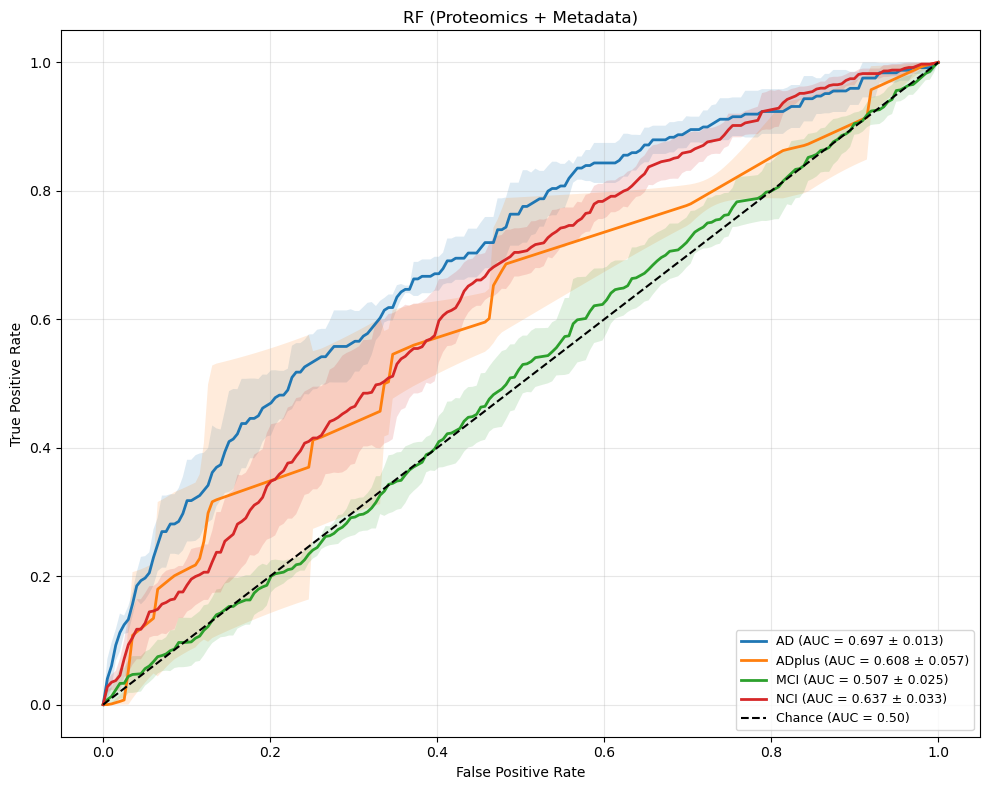

In [4]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ---- Mean ROC across seeds from saved CSVs ----
folder = "/Users/adithyamadduri/Desktop/Projects/proteomics_RF(ANML+Meta)"
files = glob.glob(os.path.join(folder, "seed*_*.csv"))
assert len(files) > 0, "No per-seed ROC CSVs found."

# Infer class names from filenames (everything after 'seedX_')
def class_from_path(p):
    base = os.path.basename(p)
    return "_".join(base.split("_")[1:]).rsplit(".csv", 1)[0]

class_names = sorted(set(class_from_path(p) for p in files))

fpr_grid = np.linspace(0.0, 1.0, 200)

plt.figure(figsize=(10, 8))

for cls in class_names:
    cls_files = sorted(glob.glob(os.path.join(folder, f"seed*_{cls}.csv")))
    if not cls_files:
        continue

    tprs_interp, aucs = [], []

    for path in cls_files:
        df = pd.read_csv(path)
        y_true  = df["y_true"].astype(int).values
        y_score = df["y_score"].astype(float).values
        if np.unique(y_true).size < 2:
            # degenerate split; skip so it doesn't skew means
            continue

        # MATCH ratios convention: raw fpr/tpr, no dedup, no forcing tpr[-1]=1.0
        fpr, tpr, _ = roc_curve(y_true, y_score)

        # Interpolate to common grid for plotting only
        tpr_i = np.interp(fpr_grid, fpr, tpr)
        tpr_i[0] = 0.0
        tprs_interp.append(tpr_i)

        # Scalar AUC from raw fpr/tpr
        aucs.append(auc(fpr, tpr))

    if not tprs_interp:
        continue

    mean_tpr = np.mean(tprs_interp, axis=0)
    std_tpr  = np.std(tprs_interp, axis=0)
    mean_auc = float(np.mean(aucs))
    std_auc  = float(np.std(aucs))

    plt.plot(
        fpr_grid, mean_tpr, lw=2,
        label=f"{cls.replace('_',' ')} (AUC = {mean_auc:.3f} ± {std_auc:.3f})"
    )
    plt.fill_between(
        fpr_grid,
        np.clip(mean_tpr - std_tpr, 0, 1),
        np.clip(mean_tpr + std_tpr, 0, 1),
        alpha=0.15
    )

# Chance line
plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RF (Proteomics + Metadata)')
plt.legend(loc='lower right', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [8]:
# =========================
# BLOCK 2 — TRAINING
# =========================
import os
import numpy as np
import pandas as pd
from flaml import AutoML
from sklearn.metrics import roc_auc_score

# ---- Output folder ----
out_dir = "/Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)"
os.makedirs(out_dir, exist_ok=True)

# ---- Helper: group-aware stratified 70/30 split (by mode of strata per subject) ----
def group_stratified_shuffle_split(df_index, strata_all, groups_all, test_size=0.30, random_state=0):
    """Return train_idx, test_idx ensuring groups stay intact and class-sex balance is approx preserved.
       Strategy: assign each group a single stratum = mode(strata) among its rows, then stratified split at group level.
    """
    rng = np.random.RandomState(random_state)
    data = pd.DataFrame({"idx": df_index, "strata": strata_all, "group": groups_all})

    # group -> mode(strata)
    grp_mode = (
        data.groupby("group")["strata"]
        .agg(lambda s: s.value_counts().idxmax())
    )
    grp_mode = grp_mode.sample(frac=1.0, random_state=random_state)  # shuffle groups

    train_groups, test_groups = [], []
    for s_val, grp_ids in grp_mode.groupby(grp_mode.values):
        g_list = list(grp_ids.index)
        rng.shuffle(g_list)
        n_test = max(1, int(round(test_size * len(g_list))))
        test_groups.extend(g_list[:n_test])
        train_groups.extend(g_list[n_test:])

    train_mask = np.isin(groups_all, train_groups)
    test_mask  = np.isin(groups_all,  test_groups)
    return np.where(train_mask)[0], np.where(test_mask)[0]

# ---- Classes & seeds ----
classes = ["MCI","NCI","AD","AD+"]     # will save AD+ as 'ADplus' in filenames
def safe_cls(c): return c.replace("+","plus").replace(" ","_").replace("/","-")

seeds = [1,2,3,4,5]

# ---- Main loop ----
for seed in seeds:
    tr_idx, te_idx = group_stratified_shuffle_split(
        df_index=np.arange(len(X)),
        strata_all=strata,
        groups_all=groups,
        test_size=0.30,
        random_state=seed,
    )

    X_train, X_test = X.iloc[tr_idx], X.iloc[te_idx]
    y_train_full    = y[tr_idx]
    y_test_full     = y[te_idx]

    print(f"\n[Seed {seed}] Train n={len(tr_idx)} | Test n={len(te_idx)} | "
          f"Groups train={len(np.unique(groups[tr_idx]))} test={len(np.unique(groups[te_idx]))}")

    for cls in classes:
        y_train = (y_train_full == cls).astype(int)
        y_test  = (y_test_full  == cls).astype(int)

        automl = AutoML()
        settings = {
            "time_budget": 100,               # seconds per class; adjust if you want longer searches
            "metric": "roc_auc",
            "task": "classification",
            "eval_method": "cv",
            "estimator_list": ["lgbm"],       # force LightGBM
            "log_file_name": os.path.join(out_dir, f"flaml_seed{seed}_{safe_cls(cls)}.log"),
            "seed": seed,
        }
        automl.fit(X_train=X_train, y_train=y_train, **settings)
        automl.pickle(os.path.join(out_dir, f"seed{seed}_{safe_cls(cls)}_automl.pkl"))

        # Predict proba for positive class
        y_score = automl.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_score) if (y_test.sum() > 0 and y_test.sum() < len(y_test)) else float("nan")
        print(f"  [{cls}] AUC={auc:.3f}")

        # Save per-class CSV for your existing averaging/plotting script
        out_csv = os.path.join(out_dir, f"seed{seed}_{safe_cls(cls)}.csv")
        pd.DataFrame({"y_true": y_test.astype(int), "y_score": y_score.astype(float)}).to_csv(out_csv, index=False)


[Seed 1] Train n=670 | Test n=283 | Groups train=610 test=261
[flaml.automl.logger: 08-31 22:20:33] {1752} INFO - task = classification
[flaml.automl.logger: 08-31 22:20:33] {1763} INFO - Evaluation method: cv
[flaml.automl.logger: 08-31 22:20:33] {1862} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 08-31 22:20:33] {1979} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl.logger: 08-31 22:20:33] {2282} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 08-31 22:20:35] {2417} INFO - Estimated sufficient time budget=19592s. Estimated necessary time budget=20s.
[flaml.automl.logger: 08-31 22:20:35] {2466} INFO -  at 3.7s,	estimator lgbm's best error=0.3928,	best estimator lgbm's best error=0.3928
[flaml.automl.logger: 08-31 22:20:35] {2282} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 08-31 22:20:37] {2466} INFO -  at 5.6s,	estimator lgbm's best error=0.3928,	best estimator lgbm's best error=0.3928
[flaml.automl.logger: 08-31 

In [15]:
import os
import pickle
import pandas as pd
from collections import Counter

# ---- Config ----
out_dir = "/Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)"
classes = ["MCI", "NCI", "AD", "AD+"]
seeds = [1, 2, 3, 4, 5]

def safe_cls(c): return c.replace("+", "plus").replace(" ", "_").replace("/", "-")

# ---- Track all features with non-zero importance ----
feature_counts = Counter()

for seed in seeds:
    for cls in classes:
        model_path = os.path.join(out_dir, f"seed{seed}_{safe_cls(cls)}_automl.pkl")
        if not os.path.exists(model_path):
            print(f"Missing: {model_path}")
            continue

        with open(model_path, "rb") as f:
            automl = pickle.load(f)

        # Get feature importances
        importances = automl.model.estimator.feature_importances_
        features = automl.feature_names_in_

        # Filter to non-zero importance
        nonzero_features = [feat for feat, imp in zip(features, importances) if imp > 0]

        # Update count for each non-zero feature
        feature_counts.update(nonzero_features)

# ---- Filter to features appearing in at least 3 models ----
shared_features = [feat for feat, count in feature_counts.items() if count >= 3]
print(f"\n Found {len(shared_features)} features with non-zero importance in ≥3 models.\n")
print(shared_features)


 Found 338 features with non-zero importance in ≥3 models.

['10451-11', '11546-7', '14227-21', '21207-1', '3069-52', '3214-3', '7060-2', '7839-99', 'age_at_visit', 'APOE_34', '10000-28', '10085-25', '10367-62', '10462-14', '10565-19', '10569-28', '10672-75', '10705-14', '10714-7', '10816-150', '10980-11', '11089-7', '11135-5', '11142-11', '11192-168', '11243-90', '11293-14', '11351-233', '11436-6', '11450-110', '11457-53', '11516-7', '11814-29', '12077-32', '12384-92', '12430-78', '12650-43', '12712-9', '12727-7', '12904-180', '13098-93', '13118-5', '13406-161', '13453-2', '13496-19', '13567-1', '13610-9', '13692-154', '13710-6', '13732-79', '14005-2', '14091-42', '14105-5', '14115-34', '14689-3', '15391-114', '15468-14', '15491-20', '15503-15', '15503-20', '15559-5', '15635-4', '15653-9', '16292-288', '16320-139', '16614-27', '16916-19', '17170-15', '17672-184', '17685-9', '17710-40', '18175-65', '18337-4', '18411-83', '18831-6', '19112-2', '19206-20', '19238-12', '19264-6', '19296-

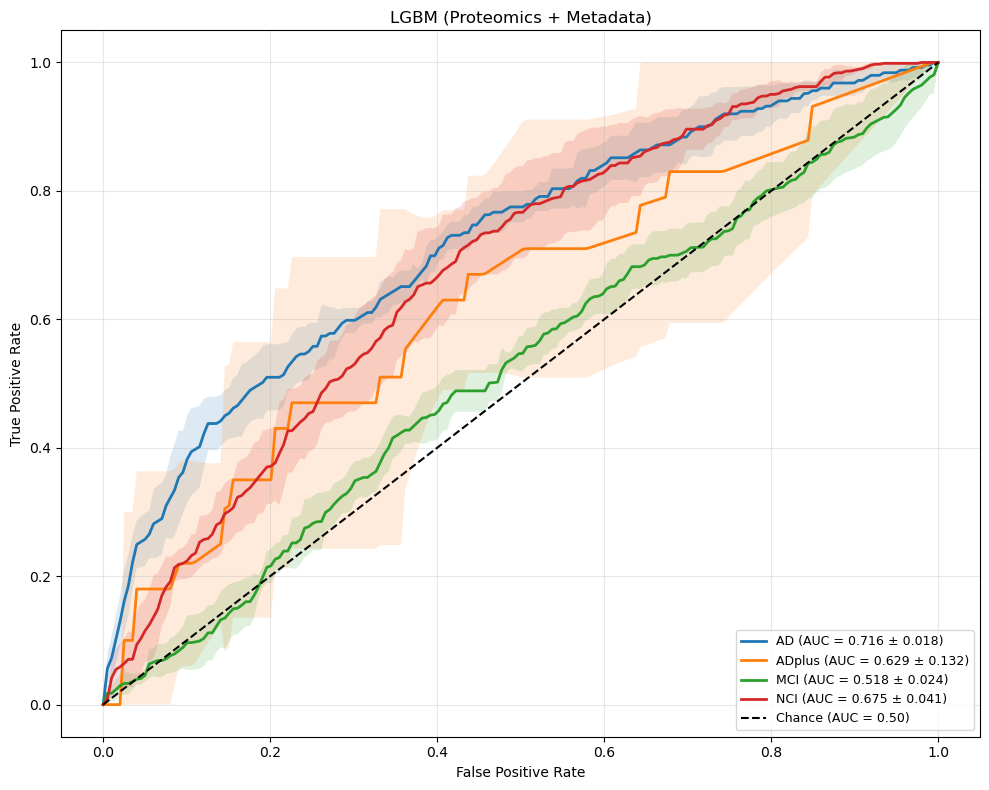

In [3]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ---- Update this to match your proteomics run ----
folder = "/Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)"
files = glob.glob(os.path.join(folder, "seed*_*.csv"))

# Infer class names from filenames (everything after 'seedX_')
def class_from_path(p):
    base = os.path.basename(p)
    return "_".join(base.split("_")[1:]).rsplit(".csv", 1)[0]

class_names = sorted(set(class_from_path(p) for p in files))

fpr_grid = np.linspace(0.0, 1.0, 200)

plt.figure(figsize=(10, 8))

for cls in class_names:
    cls_files = sorted(glob.glob(os.path.join(folder, f"seed*_{cls}.csv")))
    if not cls_files:
        continue

    tprs_interp, aucs = [], []

    for path in cls_files:
        df = pd.read_csv(path)
        y_true  = df["y_true"].astype(int).values
        y_score = df["y_score"].astype(float).values

        # EXACTLY like your ratios plot: use raw fpr/tpr directly
        fpr, tpr, _ = roc_curve(y_true, y_score)

        # Interpolate to common grid (no FPR de-dup)
        tpr_i = np.interp(fpr_grid, fpr, tpr)
        tpr_i[0] = 0.0  # match your ratios script
        tprs_interp.append(tpr_i)

        # AUC computed on raw fpr/tpr (no de-dup)
        aucs.append(auc(fpr, tpr))

    if not tprs_interp:
        continue

    mean_tpr = np.mean(tprs_interp, axis=0)
    std_tpr  = np.std(tprs_interp, axis=0)
    mean_auc = float(np.mean(aucs))
    std_auc  = float(np.std(aucs))

    plt.plot(
        fpr_grid, mean_tpr, lw=2,
        label=f"{cls.replace('_',' ')} (AUC = {mean_auc:.3f} ± {std_auc:.3f})"
    )
    plt.fill_between(
        fpr_grid,
        np.clip(mean_tpr - std_tpr, 0, 1),
        np.clip(mean_tpr + std_tpr, 0, 1),
        alpha=0.15
    )

# Chance line
plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LGBM (Proteomics + Metadata)')
plt.legend(loc='lower right', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

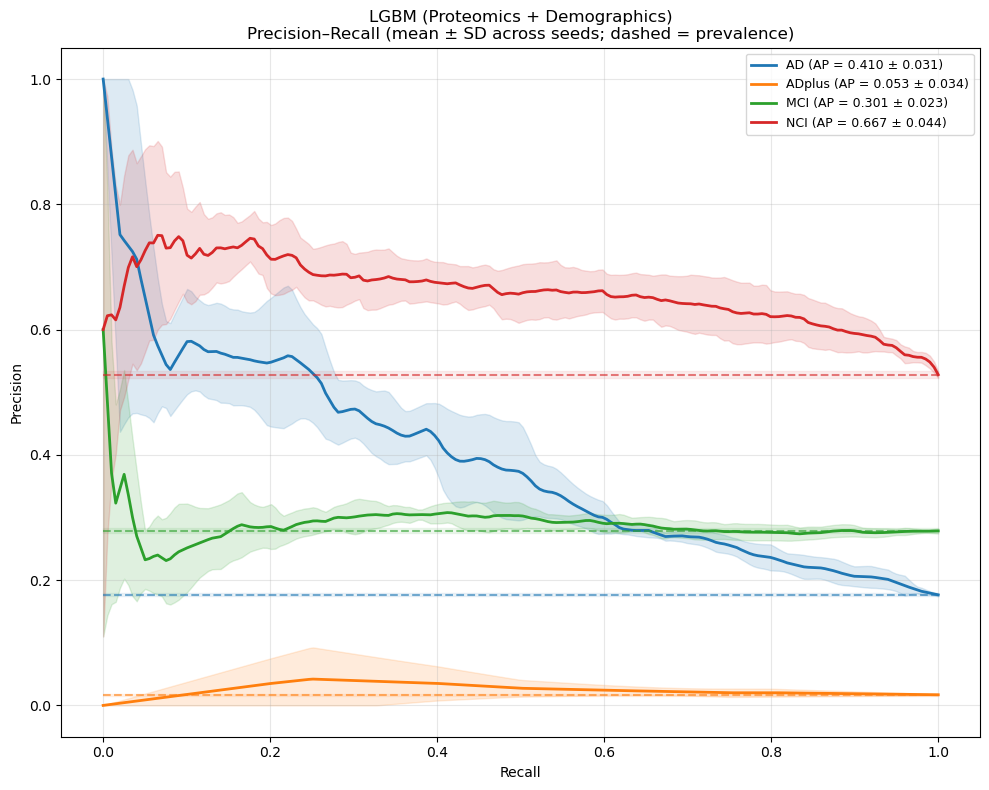

Saved plot to: /Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)/pr_mean_across_seeds.png
Saved AP summary to: /Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)/pr_ap_summary.csv
 Class  Mean_AP   Std_AP  Prev_Mean  Prev_SD  N
    AD 0.410182 0.031111   0.176479 0.002401  5
ADplus 0.053145 0.034425   0.017004 0.001345  5
   MCI 0.301119 0.023089   0.278570 0.004115  5
   NCI 0.667049 0.044348   0.527947 0.005547  5


<Figure size 640x480 with 0 Axes>

In [3]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# ---- Update this to match your proteomics run ----
folder = "/Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)"
files = glob.glob(os.path.join(folder, "seed*_*.csv"))

# Infer class names from filenames (everything after 'seedX_')
def class_from_path(p):
    base = os.path.basename(p)
    return "_".join(base.split("_")[1:]).rsplit(".csv", 1)[0]

class_names = sorted(set(class_from_path(p) for p in files))

recall_grid = np.linspace(0.0, 1.0, 200)
plt.figure(figsize=(10, 8))

ap_summary_rows = []

for cls in class_names:
    cls_files = sorted(glob.glob(os.path.join(folder, f"seed*_{cls}.csv")))
    if not cls_files:
        continue

    prec_interp_list, aps, prevalences = [], [], []

    for path in cls_files:
        df = pd.read_csv(path)
        y_true  = df["y_true"].astype(int).values
        y_score = df["y_score"].astype(float).values

        # skip degenerate splits
        pos = y_true.sum()
        if pos == 0 or pos == len(y_true):
            continue

        precision, recall, _ = precision_recall_curve(y_true, y_score)

        # deduplicate recall for interpolation
        uniq_idx = np.unique(recall, return_index=True)[1]
        r_u, p_u = recall[uniq_idx], precision[uniq_idx]

        # interpolate precision onto common recall grid
        p_i = np.interp(recall_grid, r_u, p_u, left=p_u[0], right=p_u[-1])
        prec_interp_list.append(p_i)

        aps.append(average_precision_score(y_true, y_score))
        prevalences.append(y_true.mean())

    if not prec_interp_list:
        print(f"[WARN] No valid PR curves for class {cls}")
        continue

    mean_prec = np.mean(prec_interp_list, axis=0)
    std_prec  = np.std(prec_interp_list, axis=0)
    mean_ap   = float(np.mean(aps))
    std_ap    = float(np.std(aps))
    n_splits  = len(aps)

    label_cls = cls.replace("_", " ")
    line, = plt.plot(recall_grid, mean_prec, lw=2,
                     label=f"{label_cls} (AP = {mean_ap:.3f} ± {std_ap:.3f})")
    plt.fill_between(recall_grid,
                     np.clip(mean_prec - std_prec, 0, 1),
                     np.clip(mean_prec + std_prec, 0, 1),
                     alpha=0.15, color=line.get_color())

    # per-class chance baseline = prevalence
    prev_mean = float(np.mean(prevalences))
    prev_sd   = float(np.std(prevalences))
    plt.hlines(prev_mean, 0, 1, colors=line.get_color(), linestyles="--", alpha=0.6)
    low, high = max(0, prev_mean - prev_sd), min(1, prev_mean + prev_sd)
    plt.fill_between([0, 1], [low, low], [high, high], color=line.get_color(), alpha=0.08)

    ap_summary_rows.append({
        "Class": label_cls, "Mean_AP": mean_ap, "Std_AP": std_ap,
        "Prev_Mean": prev_mean, "Prev_SD": prev_sd, "N": n_splits
    })

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("LGBM (Proteomics + Demographics)\nPrecision–Recall (mean ± SD across seeds; dashed = prevalence)")
plt.legend(loc="upper right", fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Optional: save figure + table
plot_path = os.path.join(folder, "pr_mean_across_seeds.png")
plt.savefig(plot_path, dpi=200)
if ap_summary_rows:
    ap_df = pd.DataFrame(ap_summary_rows).sort_values("Class")
    ap_csv = os.path.join(folder, "pr_ap_summary.csv")
    ap_df.to_csv(ap_csv, index=False)
    print(f"Saved plot to: {plot_path}")
    print(f"Saved AP summary to: {ap_csv}")
    print(ap_df.to_string(index=False))